
# Semana 6 — Diagnóstico de Overfitting & Underfitting 🧪

Neste caderno você vai:
- Treinar **3 MLPs** (underfit / overfit / equilibrado) no `make_moons`.
- Ver **curvas de aprendizado** (loss treino/validação).
- Visualizar **fronteiras de decisão**.
- Comparar **acurácia em treino e teste** para detectar gaps.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


## 1) Dados não lineares (make_moons)

In [2]:

X, y = make_moons(n_samples=1200, noise=0.25, random_state=42)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

X_tr_s.shape, X_te_s.shape


((900, 2), (300, 2))

## 2) Funções auxiliares

In [3]:

def plot_boundary(model, X, y, title=""):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(6.2,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=18)
    plt.title(title); plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.tight_layout(); plt.show()

def summarize_model(name, model, X_tr, y_tr, X_te, y_te):
    acc_tr = accuracy_score(y_tr, model.predict(X_tr))
    acc_te = accuracy_score(y_te, model.predict(X_te))
    print(f"{name}: acc_treino={acc_tr:.3f} | acc_teste={acc_te:.3f}")
    return acc_tr, acc_te


## 3) Caso 1 — Underfitting

/Users/yandrade/PycharmProjects/ia_study/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


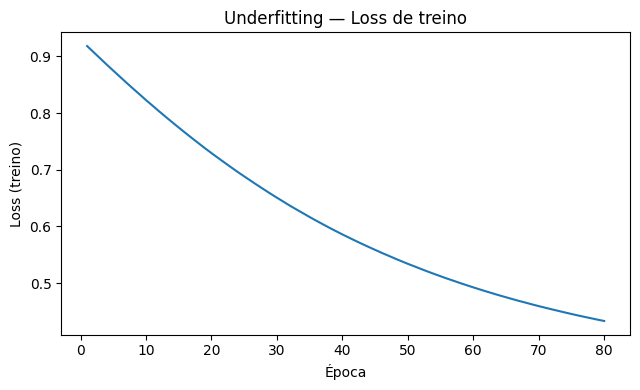

UNDERFIT: acc_treino=0.827 | acc_teste=0.813


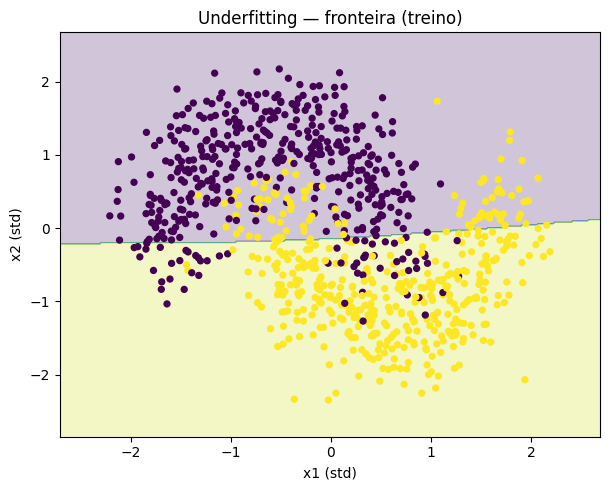

In [4]:

mlp_under = MLPClassifier(hidden_layer_sizes=(4,), activation='tanh',
                          alpha=1e-2, max_iter=80, random_state=42,
                          solver='adam', learning_rate='adaptive', verbose=False,
                          early_stopping=False)
mlp_under.fit(X_tr_s, y_tr)

# Curva de loss (apenas treino, sem ES)
loss_curve_under = getattr(mlp_under, 'loss_curve_', None)
if loss_curve_under is not None:
    plt.figure(figsize=(6.5,4))
    plt.plot(range(1, len(loss_curve_under)+1), loss_curve_under)
    plt.xlabel('Época'); plt.ylabel('Loss (treino)'); plt.title('Underfitting — Loss de treino')
    plt.tight_layout(); plt.show()

summarize_model('UNDERFIT', mlp_under, X_tr_s, y_tr, X_te_s, y_te)
plot_boundary(mlp_under, X_tr_s, y_tr, 'Underfitting — fronteira (treino)')


## 4) Caso 2 — Overfitting

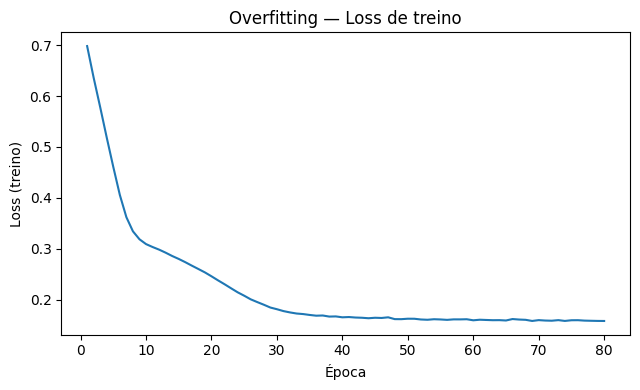

OVERFIT: acc_treino=0.937 | acc_teste=0.950


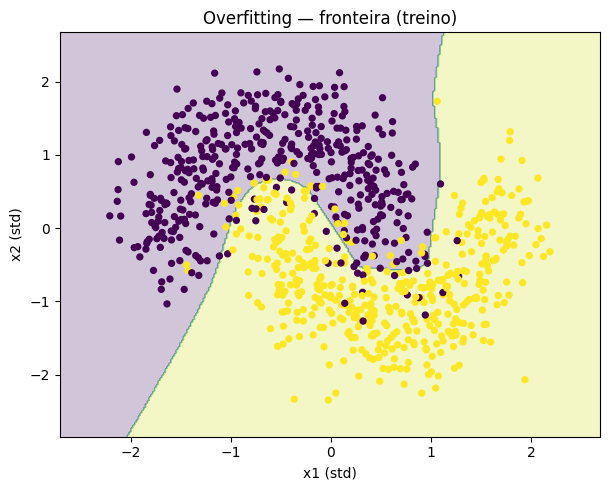

In [5]:

mlp_over = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu',
                         alpha=1e-6, max_iter=600, random_state=42,
                         solver='adam', learning_rate='constant', learning_rate_init=1e-3,
                         verbose=False, early_stopping=False)
mlp_over.fit(X_tr_s, y_tr)

loss_curve_over = getattr(mlp_over, 'loss_curve_', None)
if loss_curve_over is not None:
    plt.figure(figsize=(6.5,4))
    plt.plot(range(1, len(loss_curve_over)+1), loss_curve_over)
    plt.xlabel('Época'); plt.ylabel('Loss (treino)'); plt.title('Overfitting — Loss de treino')
    plt.tight_layout(); plt.show()

summarize_model('OVERFIT', mlp_over, X_tr_s, y_tr, X_te_s, y_te)
plot_boundary(mlp_over, X_tr_s, y_tr, 'Overfitting — fronteira (treino)')


## 5) Caso 3 — Equilíbrio (regularização + early stopping)

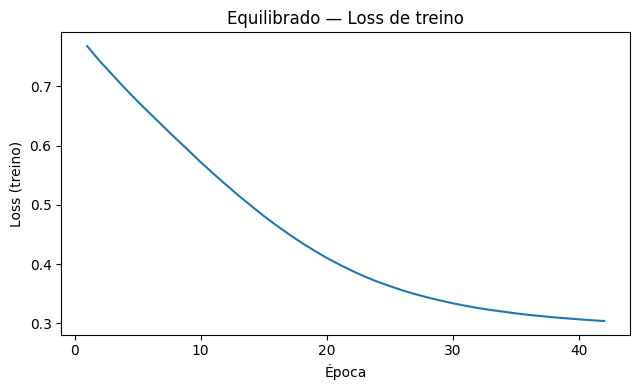

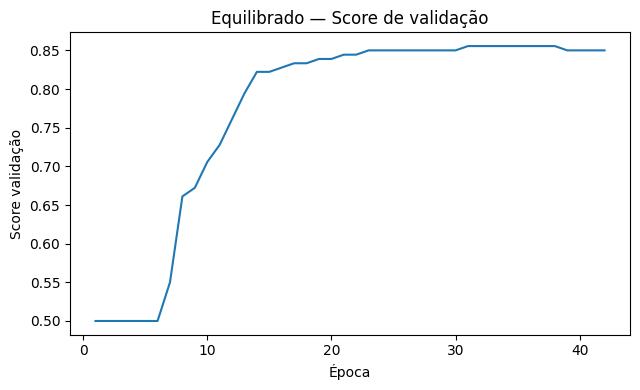

BALANCED: acc_treino=0.861 | acc_teste=0.873


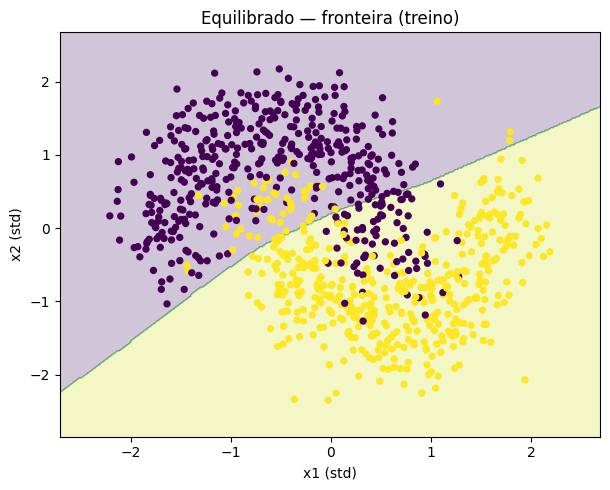

In [6]:

mlp_bal = MLPClassifier(hidden_layer_sizes=(32,16), activation='relu',
                        alpha=1e-3, max_iter=600, random_state=42,
                        solver='adam', learning_rate='adaptive', learning_rate_init=1e-3,
                        early_stopping=True, n_iter_no_change=10, validation_fraction=0.2,
                        verbose=False)
mlp_bal.fit(X_tr_s, y_tr)

loss_curve_bal = getattr(mlp_bal, 'loss_curve_', None)
val_scores = getattr(mlp_bal, 'validation_scores_', None)

if loss_curve_bal is not None:
    plt.figure(figsize=(6.5,4))
    plt.plot(range(1, len(loss_curve_bal)+1), loss_curve_bal)
    plt.xlabel('Época'); plt.ylabel('Loss (treino)'); plt.title('Equilibrado — Loss de treino')
    plt.tight_layout(); plt.show()

if val_scores is not None:
    plt.figure(figsize=(6.5,4))
    plt.plot(range(1, len(val_scores)+1), val_scores)
    plt.xlabel('Época'); plt.ylabel('Score validação'); plt.title('Equilibrado — Score de validação')
    plt.tight_layout(); plt.show()

summarize_model('BALANCED', mlp_bal, X_tr_s, y_tr, X_te_s, y_te)
plot_boundary(mlp_bal, X_tr_s, y_tr, 'Equilibrado — fronteira (treino)')


## 6) Comparativo rápido

In [7]:

rows = []
for name, model in [('UNDERFIT', mlp_under), ('OVERFIT', mlp_over), ('BALANCED', mlp_bal)]:
    acc_tr = accuracy_score(y_tr, model.predict(X_tr_s))
    acc_te = accuracy_score(y_te, model.predict(X_te_s))
    gap = acc_tr - acc_te
    rows.append((name, acc_tr, acc_te, gap))

pd.DataFrame(rows, columns=['modelo','acc_treino','acc_teste','gap_(treino-teste)']).sort_values('acc_teste', ascending=False)


,modelo,acc_treino,acc_teste,gap_(treino-teste)
1,OVERFIT,0.936667,0.950000,-0.013333
2,BALANCED,0.861111,0.873333,-0.012222
0,UNDERFIT,0.826667,0.813333,0.013333



## 7) Checklist prático
- **Gap grande** (treino ≫ teste) → Overfitting → ↑regularização (`alpha`), **early stopping**, ↓complexidade.
- **Treino ruim** e **teste ruim** → Underfitting → ↑complexidade, ↑épocas, ↓regularização.
- Sempre padronize os dados e, se possível, use **validação** (ex.: `validation_fraction`).
